Heart Disease Prediction - Comprehensive Analysis  
Date: 2026-01-04  

This notebook performs end-to-end machine learning pipeline for predicting heart disease based on medical indicators.

In [5]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)

import xgboost as xgb
import joblib

# 1. Settings

In [6]:
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✅ All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")

✅ All libraries imported successfully!
Pandas version: 2.2.2
Scikit-learn version: 1.6.1


# 2. Load Dataset
Load the Heart Disease dataset from Kaggle  
Dataset: https://www.kaggle.com/datasets/rishidamarla/heart-disease-prediction

In [13]:
df = pd.read_csv('data/heart_disease.csv')
print("✅ Dataset loaded successfully!")
print(f"\nDataset shape: {df.shape}")
print(f"Number of samples: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")
df.head(3)

✅ Dataset loaded successfully!

Dataset shape: (270, 14)
Number of samples: 270
Number of features: 14


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence


# 3. Initial Data Exploration

In [14]:
# Quick overview of the dataset structure

print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)

# First rows
print("\n📊 First 5 rows:")
display(df.head())

print("\n📊 Last 5 rows:")
display(df.tail())

# Data types and non-null counts
print("\n📋 Dataset Info:")
df.info()


DATASET OVERVIEW

📊 First 5 rows:


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence



📊 Last 5 rows:


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
265,52,1,3,172,199,1,0,162,0,0.5,1,0,7,Absence
266,44,1,2,120,263,0,0,173,0,0.0,1,0,7,Absence
267,56,0,2,140,294,0,2,153,0,1.3,2,0,3,Absence
268,57,1,4,140,192,0,0,148,0,0.4,2,0,6,Absence
269,67,1,4,160,286,0,2,108,1,1.5,2,3,3,Presence



📋 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      270 non-null    int64  
 1   Sex                      270 non-null    int64  
 2   Chest pain type          270 non-null    int64  
 3   BP                       270 non-null    int64  
 4   Cholesterol              270 non-null    int64  
 5   FBS over 120             270 non-null    int64  
 6   EKG results              270 non-null    int64  
 7   Max HR                   270 non-null    int64  
 8   Exercise angina          270 non-null    int64  
 9   ST depression            270 non-null    float64
 10  Slope of ST              270 non-null    int64  
 11  Number of vessels fluro  270 non-null    int64  
 12  Thallium                 270 non-null    int64  
 13  Heart Disease            270 non-null    object 
dtypes: float6

# 4. Feature Description

In [15]:
# Understanding each feature in the dataset

feature_descriptions = {
    'age': 'Age in years',
    'sex': 'Sex (1 = male; 0 = female)',
    'cp': 'Chest pain type (0-3)',
    'trestbps': 'Resting blood pressure (mm Hg)',
    'chol': 'Serum cholesterol (mg/dl)',
    'fbs': 'Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)',
    'restecg': 'Resting electrocardiographic results (0-2)',
    'thalach': 'Maximum heart rate achieved',
    'exang': 'Exercise induced angina (1 = yes; 0 = no)',
    'oldpeak': 'ST depression induced by exercise relative to rest',
    'slope': 'Slope of peak exercise ST segment (0-2)',
    'ca': 'Number of major vessels colored by fluoroscopy (0-3)',
    'thal': 'Thalassemia (1 = normal; 2 = fixed defect; 3 = reversible defect)',
    'target': 'Heart disease diagnosis (1 = disease; 0 = no disease)'
}

print("=" * 80)
print("FEATURE DESCRIPTIONS")
print("=" * 80)
for feature, description in feature_descriptions.items():
    print(f"• {feature:12s}: {description}")

FEATURE DESCRIPTIONS
• age         : Age in years
• sex         : Sex (1 = male; 0 = female)
• cp          : Chest pain type (0-3)
• trestbps    : Resting blood pressure (mm Hg)
• chol        : Serum cholesterol (mg/dl)
• fbs         : Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
• restecg     : Resting electrocardiographic results (0-2)
• thalach     : Maximum heart rate achieved
• exang       : Exercise induced angina (1 = yes; 0 = no)
• oldpeak     : ST depression induced by exercise relative to rest
• slope       : Slope of peak exercise ST segment (0-2)
• ca          : Number of major vessels colored by fluoroscopy (0-3)
• thal        : Thalassemia (1 = normal; 2 = fixed defect; 3 = reversible defect)
• target      : Heart disease diagnosis (1 = disease; 0 = no disease)


# 5. Statistical Summary

In [16]:
# Statistical summary of numerical features

print("=" * 80)
print("STATISTICAL SUMMARY")
print("=" * 80)

# Descriptive statistics
print("\n📈 Numerical Features Statistics:")
display(df.describe().T)

print("\n📊 Categorical Features Value Counts:")
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']

for col in categorical_cols:
    if col in df.columns:
        print(f"\n{col}:")
        print(df[col].value_counts().sort_index())

STATISTICAL SUMMARY

📈 Numerical Features Statistics:


,count,mean,std,min,25%,50%,75%,max
Age,270.0,54.433333,9.109067,29.0,48.0,55.0,61.0,77.0
Sex,270.0,0.677778,0.468195,0.0,0.0,1.0,1.0,1.0
Chest pain type,270.0,3.174074,0.950090,1.0,3.0,3.0,4.0,4.0
BP,270.0,131.344444,17.861608,94.0,120.0,130.0,140.0,200.0
Cholesterol,270.0,249.659259,51.686237,126.0,213.0,245.0,280.0,564.0
FBS over 120,270.0,0.148148,0.355906,0.0,0.0,0.0,0.0,1.0
EKG results,270.0,1.022222,0.997891,0.0,0.0,2.0,2.0,2.0
Max HR,270.0,149.677778,23.165717,71.0,133.0,153.5,166.0,202.0
Exercise angina,270.0,0.329630,0.470952,0.0,0.0,0.0,1.0,1.0
ST depression,270.0,1.050000,1.145210,0.0,0.0,0.8,1.6,6.2



📊 Categorical Features Value Counts:


# 6. Missing Values Analysis

In [17]:
# Check for missing values and data quality issues

print("=" * 80)
print("MISSING VALUES ANALYSIS")
print("=" * 80)

# Missing values count
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing_Count': missing_values,
    'Missing_Percent': missing_percent
})

print("\n🔍 Missing Values Summary:")
print(missing_df[missing_df['Missing_Count'] > 0])

if missing_df['Missing_Count'].sum() == 0:
    print("\n✅ No missing values found! Data quality is excellent.")
else:
    print(f"\n⚠️ Total missing values: {missing_df['Missing_Count'].sum()}")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\n🔍 Duplicate rows: {duplicates}")

if duplicates > 0:
    print(f"⚠️ Found {duplicates} duplicate rows. Consider removing them.")
    df = df.drop_duplicates()
    print(f"✅ Duplicates removed. New shape: {df.shape}")

MISSING VALUES ANALYSIS

🔍 Missing Values Summary:
Empty DataFrame
Columns: [Missing_Count, Missing_Percent]
Index: []

✅ No missing values found! Data quality is excellent.

🔍 Duplicate rows: 0


# 7. Target Variable Analysis

TARGET VARIABLE ANALYSIS

🎯 Target Variable Distribution:
Absence (0): 150 (55.56%)
Presence (1):    120 (44.44%)

Imbalance Ratio: 1.25
⚠️ Minor imbalance detected. Consider using stratified sampling.


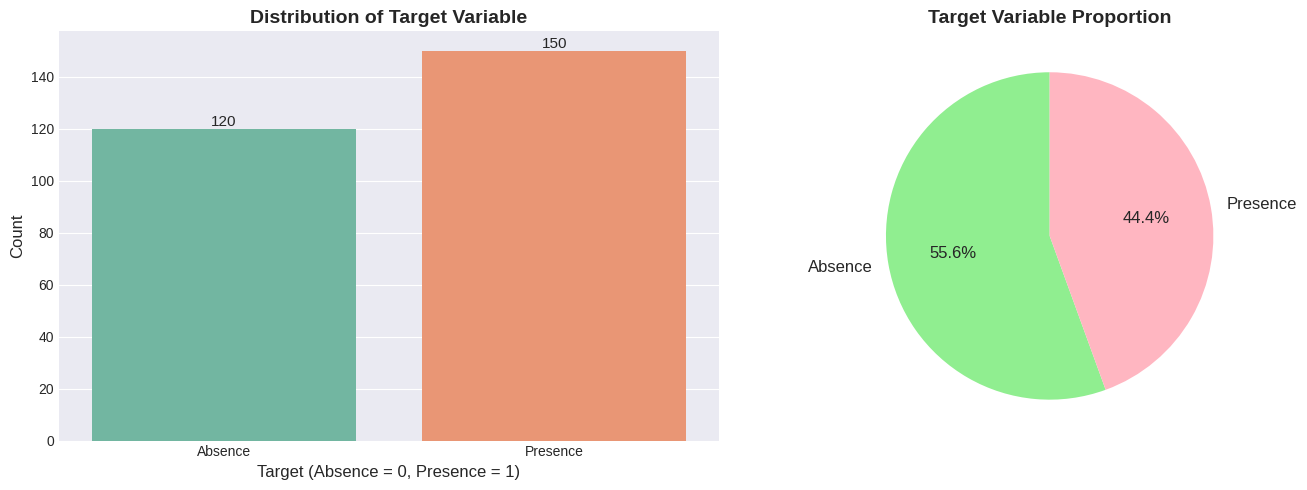

In [25]:
# Analyze the distribution of the target variable (class balance)

print("=" * 80)
print("TARGET VARIABLE ANALYSIS")
print("=" * 80)

# Class distribution
target_counts = df['Heart Disease'].value_counts() # Changed 'target' to 'Heart Disease'
target_percent = (target_counts / len(df)) * 100

print("\n🎯 Target Variable Distribution:")
# Ensure labels match the actual values in 'Heart Disease' column
# The dataset description maps 'Presence' to 1 and 'Absence' to 0 if it were numerical.
# Since it's object, we'll use the actual string values.
print(f"Absence (0): {target_counts.get('Absence', 0)} ({target_percent.get('Absence', 0):.2f}%)") # Fixed closing quote
print(f"Presence (1):    {target_counts.get('Presence', 0)} ({target_percent.get('Presence', 0):.2f}%)") # Fixed closing quote

# Calculate imbalance ratio
# Ensure the division handles potential missing keys if one class is absent
# And convert to numerical for calculation if not already.
imbalance_ratio = target_counts.get('Absence', 0) / target_counts.get('Presence', 1) # Added .get for safety
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}")

if abs(imbalance_ratio - 1) < 0.2:
    print("✅ Dataset is well-balanced!")
elif abs(imbalance_ratio - 1) < 0.5:
    print("⚠️ Minor imbalance detected. Consider using stratified sampling.")
else:
    print("⚠️ Significant imbalance! Consider using SMOTE or class weights.")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(x='Heart Disease', data=df, ax=axes[0], palette='Set2') # Changed 'target' to 'Heart Disease'
axes[0].set_title('Distribution of Target Variable', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Target (Absence = 0, Presence = 1)', fontsize=12) # Updated xlabel
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels(['Absence', 'Presence']) # Updated xticklabels

# Add counts on bars
for container in axes[0].containers:
    axes[0].bar_label(container, fontsize=11)

# Pie chart
colors = ['#90EE90', '#FFB6C1']
axes[1].pie(target_counts, labels=['Absence', 'Presence'], autopct='%1.1f%%',
            colors=colors, startangle=90, textprops={'fontsize': 12}) # Updated labels
axes[1].set_title('Target Variable Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()